In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

In [3]:
#Loading the data
train = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge', 'train.csv', 'train.csv'))
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
#Preprocessing the data
from tensorflow.keras.layers import TextVectorization
x=train['comment_text']
y=train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
MAX_FEATURES = 300000
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=1000, output_mode='int')
vectorizer.adapt(x.values)
# print(y)


In [5]:
# vectorizer.get_vocabulary()
vectorized_text = vectorizer(x.values)

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
# dataset = dataset.shuffle(buffer_size=1024).batch(64)
dataset=dataset.cache()
dataset=dataset.shuffle(160000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)


In [7]:
batch_X,batch_y =dataset.as_numpy_iterator().next()
# batch_X, batch_y = next(iter(dataset))
batch_X.shape, batch_y.shape

((16, 1000), (16, 6))

In [8]:
train_size = int(0.7 * len(dataset))
# test_size = int(0.15 * len(dataset))
train_ds = dataset.take(train_size)
val=dataset.skip(train_size).take(int(0.2 * len(dataset)))
test=dataset.skip(int(len(dataset)*0.9)).take(int(0.1 * len(dataset)))
# len(train_ds),len(val),len(test)
train_generator=train_ds.as_numpy_iterator()
train_generator.next()


(array([[    46,    235,     10, ...,      0,      0,      0],
        [ 90615,     17,  92682, ...,      0,      0,      0],
        [    40,     88,      8, ...,      0,      0,      0],
        ...,
        [ 10373,    171,     11, ...,      0,      0,      0],
        [   150,    262,    425, ...,      0,      0,      0],
        [157188,  40435,     18, ...,      0,      0,      0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]], dtype=int64))

In [9]:
#sequential model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
model=Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='sigmoid'))
#converting the model to labels
model.compile(loss='binary_crossentropy', optimizer='adam')
# model.compile(optimizer='adam',loss='binary_crossentropy')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
history=model.fit(train_ds,validation_data=val,epochs=1)


6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1596s 229ms/step - loss: 0.0449 - val_loss: 0.0397


<Figure size 1000x600 with 0 Axes>

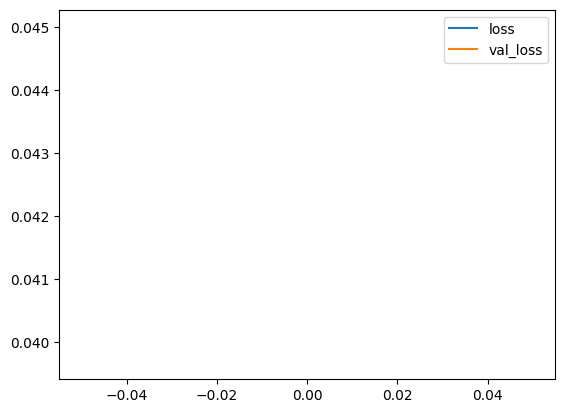

In [15]:
# history.historyddd
from matplotlib import pyplot as plt
plt.figure(figsize=(10,6))
pd.DataFrame(history.history).plot()
plt.show()

In [17]:
input_text=vectorizer('You freaking kill me. You')
model.predict(np.expand_dims(input_text,0))
batch_X, batch_y = test.as_numpy_iterator().next()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


array([[0.9761158 , 0.13383652, 0.8121349 , 0.05234901, 0.67745644,
        0.12202517]], dtype=float32)

In [20]:
#evaluate model
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre=Precision()
rec=Recall()
acc=CategoricalAccuracy()

for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    rec.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

# print(f'Precision: {pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

In [21]:
print(f'Precision: {pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8774383664131165, Recall:0.6589275598526001, Accuracy:0.498495489358902


In [30]:
import gradio as gr
import tensorflow as tf
model.save('model.h5')

In [31]:
model = tf.keras.models.load_model('model.h5')
input_str=  vectorizer('You are a good person')
res=model.predict(np.expand_dims(input_str,0))
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


array([[0.12698974, 0.00014815, 0.01787583, 0.00350268, 0.02990533,
        0.00567012]], dtype=float32)

In [35]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(train.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

# interface=gr.Interface(fn=score_comment,inputs=gr.inputs.Textbox(lines=5,label='Enter your comment here'),outputs='text')

In [ ]:
# gr.Interface(fn=score_comment,inputs=gr.inputs.Textbox(lines=5,label='Enter your comment here'),outputs='text').launch(share=True)
# interface.launch(share=True)

interface = gr.Interface(fn=score_comment, inputs=gr.Textbox(lines=5, label='Enter your comment here'), outputs='text')
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://5b26562a2b72e31546.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
